In [1]:
import sys, subprocess

subprocess.run(
    [sys.executable, "-m", "pip", "uninstall", "-y",
     "flwr", "protobuf", "grpcio", "flwr-datasets"],
    check=False
)

subprocess.run(
    [sys.executable, "-m", "pip", "install", "--no-cache-dir",
     "protobuf==5.29.0",
     "grpcio>=1.60.0",
     "flwr[simulation]",
     "flwr-datasets[vision]",
     "torch",
     "torchvision",
     "matplotlib"],
    check=True
)

print("✅ Installation complete")
print("⚠️ Runtime → Restart runtime (MANDATORY)")


✅ Installation complete
⚠️ Runtime → Restart runtime (MANDATORY)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Normalize, ToTensor
from torchvision.models import resnet18

import flwr as fl
from flwr.client import NumPyClient
from flwr.simulation import start_simulation
from flwr.server.strategy import FedAvg

from flwr_datasets import FederatedDataset
from flwr_datasets.partitioner import IidPartitioner

import matplotlib.pyplot as plt

NUM_CLIENTS = 2
NUM_ROUNDS = 2
BATCH_SIZE = 64
MAX_BATCHES = 30

DEVICE = torch.device("cpu")
print("Using device:", DEVICE)

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = resnet18(weights=None)
        self.model.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

def train(net, loader):
    net.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

    for i, batch in enumerate(loader):
        if i >= MAX_BATCHES:
            break
        optimizer.zero_grad()
        loss = criterion(net(batch["img"]), batch["label"])
        loss.backward()
        optimizer.step()


def test(net, loader):
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in loader:
            preds = net(batch["img"]).argmax(1)
            correct += (preds == batch["label"]).sum().item()
            total += len(preds)
    return correct / total

def load_data(cid):
    fds = FederatedDataset(
        dataset="uoft-cs/cifar10",
        partitioners={"train": IidPartitioner(num_partitions=NUM_CLIENTS)},
    )

    part = fds.load_partition(cid)
    split = part.train_test_split(test_size=0.2, seed=42)

    tf = Compose([
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    split = split.with_transform(
        lambda b: {"img": [tf(x) for x in b["img"]], "label": b["label"]}
    )

    return (
        DataLoader(split["train"], batch_size=BATCH_SIZE, shuffle=True),
        DataLoader(split["test"], batch_size=BATCH_SIZE),
    )


class FlowerClient(NumPyClient):
    def __init__(self, cid):
        self.net = Net().to(DEVICE)
        self.trainloader, self.testloader = load_data(cid)

    def get_parameters(self, config):
        return [v.cpu().numpy() for v in self.net.state_dict().values()]

    def set_parameters(self, parameters):
        self.net.load_state_dict(
            dict(zip(self.net.state_dict().keys(), map(torch.tensor, parameters))),
            strict=True
        )

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader)
        return self.get_parameters({}), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        acc = test(self.net, self.testloader)
        return 0.0, len(self.testloader.dataset), {"accuracy": acc}


def client_fn(cid):
    return FlowerClient(int(cid)).to_client()


def aggregate(results):
    total = sum(n for n, _ in results)
    acc = sum(n * m["accuracy"] for n, m in results)
    return {"accuracy": acc / total}

history = start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    client_resources={"num_cpus": 1, "num_gpus": 0},
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=FedAvg(
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=aggregate,
    ),
)

print("Final Accuracy:", history.metrics_distributed["accuracy"][-1][1])


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=2, no round_timeout


Using device: cpu


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
2025-12-30 13:56:05,679	INFO worker.py:2012 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 2.0, 'memory': 9161673114.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3926431334.0, 'GPU': 1.0, 'accelerator_type:T4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1, 'num_gpus': 0}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=1779) 

Final Accuracy: 0.3639


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


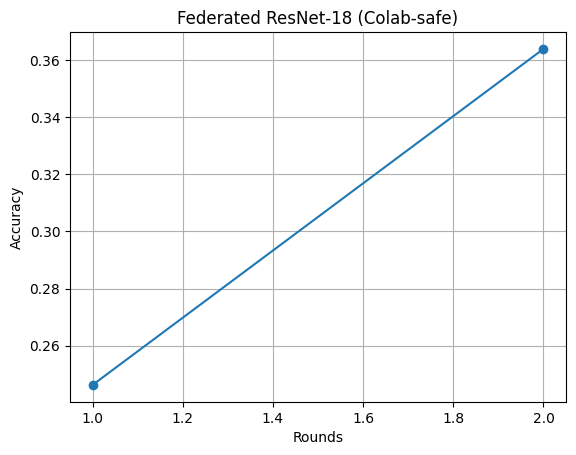

In [3]:
rounds = [r for r, _ in history.metrics_distributed["accuracy"]]
accs = [a for _, a in history.metrics_distributed["accuracy"]]

plt.plot(rounds, accs, marker="o")
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("Federated ResNet-18 (Colab-safe)")
plt.grid(True)
plt.show()
